100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [00:57<00:00, 2.95MB/s]


Epoch 1/10 — Avg Loss: 1.4682
Epoch 2/10 — Avg Loss: 1.1387
Epoch 3/10 — Avg Loss: 1.0169
Epoch 4/10 — Avg Loss: 0.9398
Epoch 5/10 — Avg Loss: 0.8877
Epoch 6/10 — Avg Loss: 0.8388
Epoch 7/10 — Avg Loss: 0.8049
Epoch 8/10 — Avg Loss: 0.7694
Epoch 9/10 — Avg Loss: 0.7445
Epoch 10/10 — Avg Loss: 0.7128

Test Accuracy: 75.95%


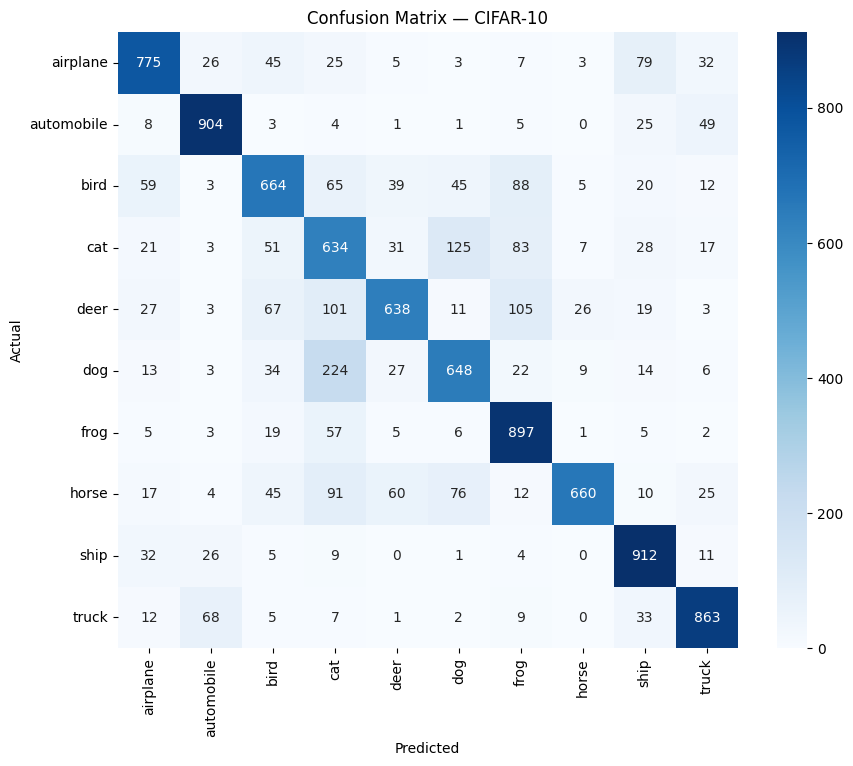

In [3]:
# Step 1: Install & Import Libraries
#!pip install torch torchvision matplotlib seaborn

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Step 2: Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

# Step 3: Define CNN Model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

# Step 4: Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 5: Training Loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/10 — Avg Loss: {total_loss/len(trainloader):.4f}')

# Step 6: Evaluation on Test Set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    correct = total = 0
    for imgs, labels in testloader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds += preds.cpu().numpy().tolist()
        all_labels += labels.cpu().numpy().tolist()
        total += labels.size(0)
        correct += (preds == labels).sum().item()

acc = correct / total
print(f'\nTest Accuracy: {acc*100:.2f}%')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix — CIFAR-10')
plt.show()
